# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [1]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

File already exists at ../data/raw\outliers_homework.csv. Skipping CSV creation to avoid overwrite.


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [2]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [3]:
data_path = Path('../data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,date,daily_return,daily_return_2
0,2022-01-03,0.001263,0.003834
1,2022-01-04,-0.020046,-0.009506
2,2022-01-05,0.004739,-0.000535
3,2022-01-06,0.009953,0.012539
4,2022-01-07,0.008872,0.009840


## TODO: Implement Outlier Functions (required)

In [4]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

*(Stretch)* Implement winsorizing (optional).

In [5]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [6]:
# target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr_col1'] = detect_outliers_iqr(df['daily_return'])
df['outlier_z_col1'] = detect_outliers_zscore(df['daily_return'], threshold=3.0)
df['outlier_iqr_col2'] = detect_outliers_iqr(df['daily_return_2'])
df['outlier_z_col2'] = detect_outliers_zscore(df['daily_return_2'], threshold=3.0)
df[['outlier_iqr_col1', 'outlier_z_col1', 'outlier_iqr_col2', 'outlier_z_col2']].mean()  # fraction flagged

outlier_iqr_col1    0.078261
outlier_z_col1      0.043478
outlier_iqr_col2    0.060870
outlier_z_col2      0.043478
dtype: float64

### Visual Checks (boxplot / histogram)

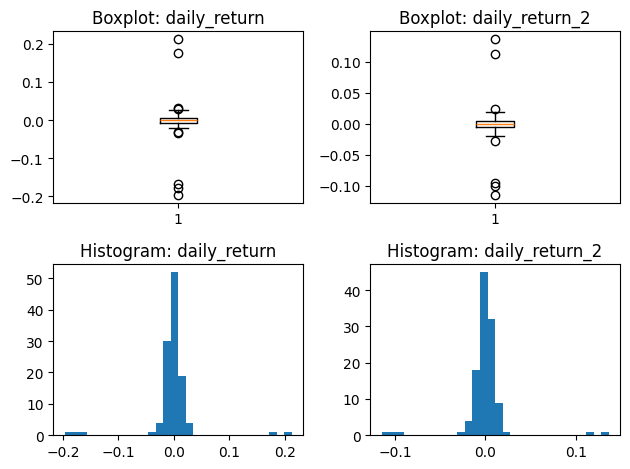

In [7]:
# plt.figure()
# plt.boxplot(df['daily_return'])
# plt.title(f'Boxplot: {"daily_return"}')
# plt.show()

# plt.figure()
# plt.hist(df['daily_return'], bins=30)
# plt.title(f'Histogram: {"daily_return"}')
# plt.show()

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)

axis[0, 0].boxplot(df['daily_return'])
axis[0, 0].set_title(f'Boxplot: {"daily_return"}')

axis[0, 1].boxplot(df['daily_return_2'])
axis[0, 1].set_title(f'Boxplot: {"daily_return_2"}')

axis[1, 0].hist(df['daily_return'], bins=30)
axis[1, 0].set_title(f'Histogram: {"daily_return"}')

axis[1, 1].hist(df['daily_return_2'], bins=30)
axis[1, 1].set_title(f'Histogram: {"daily_return_2"}')

# Combine all the operations and display
plt.tight_layout()
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [10]:
# Option A: Summary stats
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr_col1'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,-0.001434,-0.000039,-0.000251
median,-0.000187,-0.000100,-0.000187
std,0.040579,0.009443,0.010623


In [13]:
# Option B: Simple regression (if x present)
if 'daily_return_2' in df.columns:
    X_all = df[['daily_return_2']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr_col1'], ['daily_return_2']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr_col1'], target_col].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
        'mae': [mae_all, mae_flt]
    }, index=['all', 'filtered_iqr'])
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")
results

,slope,intercept,r2,mae
all,1.587569,-0.000373,0.961859,0.006333
filtered_iqr,0.972675,0.000031,0.573566,0.004903


### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

#### Methods and thresholds used (and why)
- IQR-based filtering with multiplier k=1.5
- Z-score detection with the threshold=3.0
- winsorization with lower and upper quantile=(0.05, 0.95)
- We use IQR filtering when we want to detect/flag or remove suspicious points, and we use winsorization when we want to keep all rows but blunt the influence of extremes.
#### Assumptions behind choices
- We assumed that outliers are discardable and do not have meaningful business insight.
- We chose the thresholds by standard practices: k=1.5 for IQR, z=3 to detect extreme deviations, and 5% / 95% quantile for winsorization.
#### Observed impact on results
- We observed that removing outliers by IQR-filtering substantially reduced the slope and $R^2$ (from 1.59 to 0.97 and 0.96 to 0.57), suggesting the extreme values have significant impact on the linearity.
#### Risks if assumptions are wrong (e.g., discarding true events)
- Removing outliers could be biased, as in real trading world, outliers often suggest extreme returns or losses.
- Winsorizing could hide extreme risks.